In [95]:
import os
import copy
import easydict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# log graph

In [7]:
log_data

,iterations,train_loss
0,0.0,0.338354
1,1.0,0.269935
2,2.0,0.284428
3,3.0,0.281312
4,4.0,0.448312
...,...,...
1675,1675.0,0.245065
1676,1676.0,0.399762
1677,1677.0,0.198892
1678,1678.0,0.219577


In [6]:
log_data = pd.read_csv('./result/1e-4_14_4_4.csv')

In [203]:
file_list = os.listdir('./results')

In [204]:
filenames = []
for filename in file_list:
    if 'valid_0.01_d21' in filename:
        filenames.append(filename)
print(filenames)

['valid_0.01_d21-0-7_s1_lstm-layers1_lstm-h-dim100_lstm-in-dim50_g-user-dim10_g-infect-dim10.csv']


[   0    1    2 ... 6313 6314 6315]
[0.10203383 0.01533244 0.04433483 ... 0.04789439 0.05454205 0.02406485]


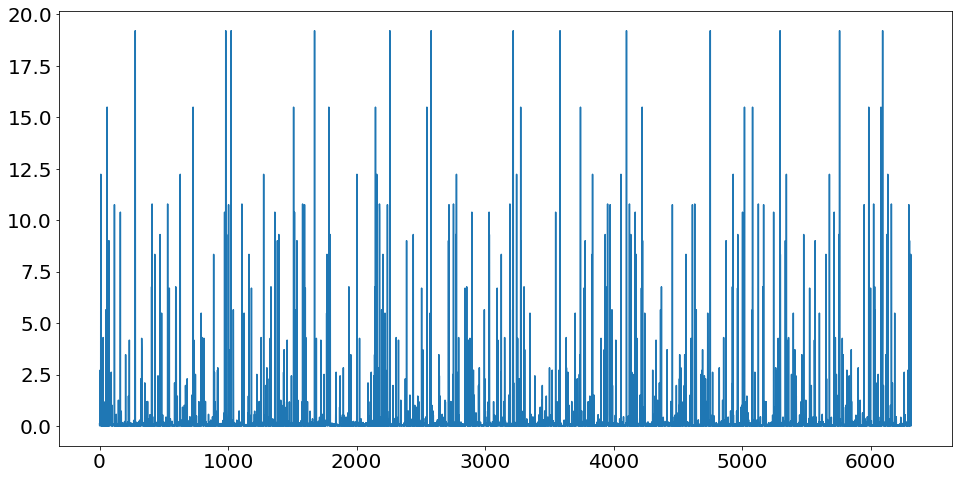

In [224]:
fig, axes = plt.subplots(1, 1, sharey=False, figsize=(16,8))

def plot_loss_logs(axes, filenames):
    for i, filename in enumerate(filenames):
        file_log = pd.read_csv(filename)
        log = np.array(file_log['train_loss'])
        xs = log.nonzero()[0]
        print(xs)
        ys = log[log.nonzero()[0]]
        print(ys)
        axes.plot(xs, ys, label=filename)
        axes.tick_params(axis='both', which='major', labelsize=20)

filenames = ['./results/train_0.01_d21-0-7_s1_lstm-layers1_lstm-h-dim100_lstm-in-dim50_g-user-dim10_g-infect-dim10.csv']
# filenames = ['./results/1e-2_d14_4_4_s7.csv']
# filenames = ['./result/5e-3_d14_4_4_s7.csv']


plot_loss_logs(axes, filenames)

In [196]:
model = torch.load('./results/models/0.01_d21-0-7_s1_lstm-layers1_lstm-h-dim100_lstm-in-dim50_g-user-dim10_g-infect-dim10/epochs_61_iter_503.pt')

In [ ]:
train_dataset, train_loader, test_dataset, test_loader = data_loader(args)

In [146]:
a = 227

str(a)

'227'

In [122]:
a/10

22.7

In [9]:
def plot_acc_logs(ax, dataset, model, shot1_filename, shot5_filename, mode='valid'):
    accuracy = mode + '_accuracy'
    colors = ['#4F81BD', '#C0504D']
    
    ax.grid(True)
    
    if dataset == 'fc100':
        ax.set_ylim([0.2, 0.5])
        ax.set_yticks([0.2, 0.3, 0.4, 0.5])
    else:
        ax.set_ylim([0.4, 0.7])
        ax.set_yticks([0.4, 0.5, 0.6, 0.7])
        
    accuracy_logs_list = []
        
    for filename in shot1_filename:
        file_logs = pd.read_csv(filename)
        accuracy_logs_list.append(np.array(file_logs[accuracy]))

    for idx, (filename, accuracy_logs) in enumerate(zip(shot1_filename, accuracy_logs_list)):
        xs = accuracy_logs.nonzero()[0]
        ys = accuracy_logs[accuracy_logs.nonzero()[0]]
        ax.plot(xs[:300], ys[:300], label=filename.split("/")[3], color=colors[idx], linestyle='--')

    accuracy_logs_list = []
    
    for filename in shot5_filename:
        file_logs = pd.read_csv(filename)
        accuracy_logs_list.append(np.array(file_logs[accuracy]))
       
    for idx, (filename, accuracy_logs) in enumerate(zip(shot5_filename, accuracy_logs_list)):
        xs = accuracy_logs.nonzero()[0]
        ys = accuracy_logs[accuracy_logs.nonzero()[0]]
        ax.plot(xs[:300], ys[:300], label=filename.split("/")[3], color=colors[idx])
    
    ax.set_xticks([0, 10000, 20000, 30000])
    ax.tick_params(axis='both', which='major', labelsize=16)

In [4]:
# both : green / ANIL : classifier / RANIL : extractor
fig, axes = plt.subplots(1, 4, sharey=False, figsize=(20,4))

for idx, dataset in enumerate(['miniimagenet', 'tieredimagenet', 'cifar_fs', 'fc100']):
    model = '4conv'

    shot1_path = './output/1shot_results'
    shot1_file_list = os.listdir(shot1_path)
    shot1_file_list = sorted([f for f in shot1_file_list if dataset in f and model in f])

    shot5_path = './output/5shot_results'
    shot5_file_list = os.listdir(shot5_path)
    shot5_file_list = sorted([f for f in shot5_file_list if dataset in f and model in f])

    shot1_filename = ['{}/{}/logs/logs.csv'.format(shot1_path, f) for f in shot1_file_list if 'both' in f or 'extractor' in f]
    shot5_filename = ['{}/{}/logs/logs.csv'.format(shot5_path, f) for f in shot5_file_list if 'both' in f or 'extractor' in f]
    plot_acc_logs(axes[idx], dataset, model, shot1_filename, shot5_filename, mode='valid')
    
# plt.show()
plt.subplots_adjust(wspace=0.2)
plt.savefig('RANIL_results.pdf', bbox_inches='tight', format='pdf')
plt.close()

In [5]:
def plot_resnet_acc_logs(ax, dataset, model, shot1_filename, shot5_filename, mode='valid'):
    accuracy = mode + '_accuracy'
    colors = ['#4F81BD', '#C0504D', '#4F81BD', '#C0504D']
    legends = ['MAML w/ last skip connection', 'RANIL w/ last skip connection', 'MAML w/o last skip connection', 'RANIL w/o last skip connection']
    
    ax.grid(True)
    
    if dataset == 'fc100':
        ax.set_ylim([0.2, 0.5])
        ax.set_yticks([0.2, 0.3, 0.4, 0.5])
    else:
        ax.set_ylim([0.55, 0.75])
        ax.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75])
        
#     accuracy_logs_list = []
        
#     for filename in shot1_filename:
#         file_logs = pd.read_csv(filename)
#         accuracy_logs_list.append(np.array(file_logs[accuracy]))

#     for idx, (filename, accuracy_logs) in enumerate(zip(shot1_filename, accuracy_logs_list)):
#         xs = accuracy_logs.nonzero()[0]
#         ys = accuracy_logs[accuracy_logs.nonzero()[0]]
#         ax.plot(xs[:200], ys[:200], label=filename.split("/")[3], color=colors[idx], linestyle='--', alpha=1.0)

    accuracy_logs_list = []
    
    for filename in shot5_filename:
        file_logs = pd.read_csv(filename)
        accuracy_logs_list.append(np.array(file_logs[accuracy]))
       
    for idx, (filename, accuracy_logs) in enumerate(zip(shot5_filename, accuracy_logs_list)):
        xs = accuracy_logs.nonzero()[0]
        ys = accuracy_logs[accuracy_logs.nonzero()[0]]
        
        if '_a_' in filename:
            ax.plot(xs[:200], ys[:200], label=legends[idx], color=colors[idx], linestyle='--')
        elif '_b_' in filename:
            ax.plot(xs[:200], ys[:200], label=legends[idx], color=colors[idx])
    
    ax.legend()
    ax.set_xticks([0, 10000, 20000])
    ax.tick_params(axis='both', which='major', labelsize=16)

In [6]:
# both : green / ANIL : classifier / RANIL : extractor
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(4,4))

for idx, dataset in enumerate(['miniimagenet']):
    model = 'resnet'

    shot1_path = './output/1shot_results'
    shot1_file_list = os.listdir(shot1_path)
    shot1_file_list = sorted([f for f in shot1_file_list if dataset in f and model in f])

    shot5_path = './output/resnet_5shot_results'
    shot5_file_list = os.listdir(shot5_path)
    shot5_file_list = sorted([f for f in shot5_file_list if dataset in f and model in f])

    shot1_filename = ['{}/{}/logs/logs.csv'.format(shot1_path, f) for f in shot1_file_list if '_a_' in f or '_b_' in f]
    shot5_filename = ['{}/{}/logs/logs.csv'.format(shot5_path, f) for f in shot5_file_list if '_a_' in f or '_b_' in f]
    plot_resnet_acc_logs(ax, dataset, model, shot1_filename, shot5_filename, mode='valid')
    
# plt.show()
plt.subplots_adjust(wspace=0.2)
plt.savefig('resnet_results.pdf', bbox_inches='tight', format='pdf')
plt.close()

# 1000 episodes test

In [7]:
def make_sample_task(dataset):
    sample_task = dataset.sample_task()
    for idx, (image, label) in enumerate(sample_task['train']):
        if idx == 0:
            s_images = image.unsqueeze(0)
            s_labels = [label]
            s_real_labels = [sample_task['train'].index[label]]
        else:
            s_images = torch.cat([s_images, image.unsqueeze(0)], dim=0)
            s_labels.append(label)
            s_real_labels.append(sample_task['train'].index[label])
    
    for idx, (image, label) in enumerate(sample_task['test']):
        if idx == 0:
            q_images = image.unsqueeze(0)
            q_labels = [label]
            q_real_labels = [sample_task['test'].index[label]]
        else:
            q_images = torch.cat([q_images, image.unsqueeze(0)], dim=0)
            q_labels.append(label)
            q_real_labels.append(sample_task['test'].index[label])
    
    s_labels = torch.tensor(s_labels).type(torch.LongTensor)
    s_real_labels = torch.tensor(s_real_labels).type(torch.LongTensor)
    q_labels = torch.tensor(q_labels).type(torch.LongTensor)
    q_real_labels = torch.tensor(q_real_labels).type(torch.LongTensor)
    return [s_images, s_labels, s_real_labels, q_images, q_labels, q_real_labels]

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def get_arguments(path, dataset, save_name):
    filename = '{}/{}_{}/logs/arguments.txt'.format(path, dataset, save_name)

    args = easydict.EasyDict()
    with open(filename) as f:
        for line in f:
            key, val = line.split(": ")
            if '\n' in val:
                val = val[:-1]
            if isfloat(val):
                if val.isdigit():
                    val = int(val)
                else:
                    val = float(val)
            if val == 'True' or val == 'False':
                val = val == 'True'
            args[key] = val
    return args

def print_accuracy(args, test_dataset, sample_tasks, iteration, NIL_testing=False, template=False, distance_criterion=None):
    device = torch.device(args.device)
    sample_number = len(sample_tasks)
    
    index = ['task{}'.format(str(i+1)) for i in range(sample_number)]
    columns = []
    columns += ['Accuracy on support set (before adaptation)', 'Accuracy on query set (before adaptation)']
    columns += ['Accuracy on support set (after adaptation)', 'Accuracy on query set (after adaptation)']
    
    if NIL_testing:
        filename_pd = '{}/{}_{}/logs/{}_nil_results_{}.csv'.format(args.output_folder, args.dataset, args.save_name, test_dataset, iteration)
    else:
        filename_pd = '{}/{}_{}/logs/{}_results_{}.csv'.format(args.output_folder, args.dataset, args.save_name, test_dataset, iteration)
    test_pd = pd.DataFrame(np.zeros([sample_number, len(columns)]), index=index, columns=columns)
    
    model = load_model(args)
    filename = '{}/{}_{}/logs/logs.csv'.format(args.output_folder, args.dataset, args.save_name)
    logs = pd.read_csv(filename)
    
    if args.model == '4conv':
        checkpoint = '{}/{}_{}/models/epochs_30000.pt'.format(args.output_folder, args.dataset, args.save_name)
    elif args.model == 'resnet':
        checkpoint = '{}/{}_{}/models/epochs_20000.pt'.format(args.output_folder, args.dataset, args.save_name)
    checkpoint = torch.load(checkpoint, map_location=device)
    
    for idx in tqdm(range(sample_number)):
        task_log = []
               
        model.load_state_dict(checkpoint, strict=True)
        model.to(device)

        support_input = sample_tasks[idx][0].to(device)
        support_target = sample_tasks[idx][1].to(device)
        support_real_target = sample_tasks[idx][2]
        query_input = sample_tasks[idx][3].to(device)
        query_target = sample_tasks[idx][4].to(device)
        query_real_target = sample_tasks[idx][5]
        
        model.train()
        
        # before adaptation
        support_features, support_logit = model(support_input)
        _, support_pred_target = torch.max(support_logit, dim=1)
                
        query_features, query_logit = model(query_input)
        _, query_pred_target = torch.max(query_logit, dim=1)
        
        if NIL_testing:
            cos = nn.CosineSimilarity()
            if template:
                support_features_mean = torch.zeros([args.num_ways, support_features.shape[1]]).to(device)
                support_target_mean = torch.zeros([args.num_ways]).to(device)
                for label in range(args.num_ways):
                    support_features_mean[label] = torch.mean(support_features[torch.where(support_target==label)], dim=0)
                    support_target_mean[label] = label
                
                if distance_criterion == "cos":
                    distance = torch.zeros([len(query_features), len(support_features_mean)])
                    for i, query_feature in enumerate(query_features):
                        distance[i] = cos(torch.cat([query_feature.unsqueeze(0)]*len(support_features_mean)), support_features_mean)
                    top_similar_idx = torch.argmax(distance, dim=1)
                elif distance_criterion == "euc":
                    distance = torch.cdist(query_features, support_features_mean)
                    top_similar_idx = torch.argmin(distance, dim=1)
                    
                query_pred_target = support_target_mean[top_similar_idx]
            else:
                if distance_criterion == "cos":
                    distance = torch.zeros([len(query_features), len(support_features)])
                    for i, query_feature in enumerate(query_features):
                        distance[i] = cos(torch.cat([query_feature.unsqueeze(0)]*len(support_features)), support_features)
                    top_similar_idx = torch.argmax(distance, dim=1)
                elif distance_criterion == "euc":
                    distance = torch.cdist(query_features, support_features)
                    top_similar_idx = torch.argmin(distance, dim=1)
                    
                query_pred_target = support_target[top_similar_idx]
        
        task_log.append((sum(support_target==support_pred_target)/float(len(support_target))).item())
        task_log.append((sum(query_target==query_pred_target)/float(len(query_target))).item())
        
        # after adaptation
        inner_loss = F.cross_entropy(support_logit, support_target)
        model.zero_grad()
        
        params = update_parameters(model, inner_loss, extractor_step_size=args.extractor_step_size, classifier_step_size=args.classifier_step_size, first_order=args.first_order)
        model.load_state_dict(params, strict=False)
        
        support_features, support_logit = model(support_input)
        _, support_pred_target = torch.max(support_logit, dim=1)
        
        query_features, query_logit = model(query_input)
        _, query_pred_target = torch.max(query_logit, dim=1)

        if NIL_testing:            
            cos = nn.CosineSimilarity()
            if template:
                support_features_mean = torch.zeros([args.num_ways, support_features.shape[1]]).to(device)
                support_target_mean = torch.zeros([args.num_ways]).to(device)
                for label in range(args.num_ways):
                    support_features_mean[label] = torch.mean(support_features[torch.where(support_target==label)], dim=0)
                    support_target_mean[label] = label
                
                if distance_criterion == "cos":
                    distance = torch.zeros([len(query_features), len(support_features_mean)])
                    for i, query_feature in enumerate(query_features):
                        distance[i] = cos(torch.cat([query_feature.unsqueeze(0)]*len(support_features_mean)), support_features_mean)
                    top_similar_idx = torch.argmax(distance, dim=1)
                elif distance_criterion == "euc":
                    distance = torch.cdist(query_features, support_features_mean)
                    top_similar_idx = torch.argmin(distance, dim=1)
                    
                query_pred_target = support_target_mean[top_similar_idx]
            else:
                if distance_criterion == "cos":
                    distance = torch.zeros([len(query_features), len(support_features)])
                    for i, query_feature in enumerate(query_features):
                        distance[i] = cos(torch.cat([query_feature.unsqueeze(0)]*len(support_features)), support_features)
                    top_similar_idx = torch.argmax(distance, dim=1)
                elif distance_criterion == "euc":
                    distance = torch.cdist(query_features, support_features)
                    top_similar_idx = torch.argmin(distance, dim=1)
                    
                query_pred_target = support_target[top_similar_idx]
            
        task_log.append((sum(support_target==support_pred_target)/float(len(support_target))).item())
        task_log.append((sum(query_target==query_pred_target)/float(len(query_target))).item())

        test_pd.iloc[idx] = task_log
    test_pd.loc[sample_number+1], test_pd.loc[sample_number+2] = test_pd.mean(axis=0), test_pd.std(axis=0)
    test_pd.index = list(test_pd.index[:sample_number]) + ['mean', 'std']
    test_pd.to_csv(filename_pd)

In [8]:
sample_number = 1000
dataset = [('miniimagenet', 'miniimagenet'), ('miniimagenet', 'cifar_fs'), ('miniimagenet', 'cub')] # test_dataset size 84

for train_dataset, test_dataset in dataset:
    for iteration in [1]:
        for num_shots in [5]:
            dataset_args = easydict.EasyDict({'folder': '/home/osilab7/hdd/ml_dataset',
                                              'dataset': test_dataset,
                                              'num_ways': 5,
                                              'num_shots': num_shots,
                                              'download': True})

            sample_tasks = [make_sample_task(load_dataset(dataset_args, 'meta_test')) for _ in tqdm(range(sample_number))]

            path = './output/resnet_5shot_results'
            model = 'resnet'
            for algorithm in ['block_a_both', 'block_b_both', 'block_a_extractor', 'block_b_extractor']:
                save_name = '{}shot_{}_{}'.format(num_shots, model, algorithm)
                args = get_arguments(path, train_dataset, save_name)
                args.folder = '/home/osilab7/hdd/ml_dataset'
                args.device = 'cuda:0'
                args.output_folder = path
                print_accuracy(args, test_dataset, sample_tasks, iteration=iteration, NIL_testing=False, template=True, distance_criterion="cos")
                print_accuracy(args, test_dataset, sample_tasks, iteration=iteration, NIL_testing=True, template=True, distance_criterion="cos")
                
for train_dataset, test_dataset in dataset:
    for iteration in [1]:
        for num_shots in [1, 5]:
            dataset_args = easydict.EasyDict({'folder': '/home/osilab7/hdd/ml_dataset',
                                              'dataset': test_dataset,
                                              'num_ways': 5,
                                              'num_shots': num_shots,
                                              'download': True})

            sample_tasks = [make_sample_task(load_dataset(dataset_args, 'meta_test')) for _ in tqdm(range(sample_number))]

            path = './output/1shot_results' if num_shots == 1 else './output/5shot_results'
            model = '4conv'
            for algorithm in ['both', 'extractor']:
                save_name = '{}shot_{}_{}'.format(num_shots, model, algorithm)
                args = get_arguments(path, train_dataset, save_name)
                args.folder = '/home/osilab7/hdd/ml_dataset'
                args.device = 'cuda:0'
                args.output_folder = path
                print_accuracy(args, test_dataset, sample_tasks, iteration=iteration, NIL_testing=False, template=True, distance_criterion="cos")
                print_accuracy(args, test_dataset, sample_tasks, iteration=iteration, NIL_testing=True, template=True, distance_criterion="cos")

  0%|          | 0/1 [00:00<?, ?it/s]

hi


100%|██████████| 1/1 [00:00<00:00, 24.55it/s]

bye


In [ ]:
sample_number = 1000
dataset = [('cifar_fs', 'miniimagenet'), ('cifar_fs', 'cifar_fs'), ('cifar_fs', 'cub')] # test_dataset size 32
for train_dataset, test_dataset in dataset:
    for iteration in [1, 2, 3, 4, 5]:
        for num_shots in [1, 5]:
            dataset_args = easydict.EasyDict({'folder': '/home/osilab7/hdd/ml_dataset',
                                              'dataset': test_dataset,
                                              'num_ways': 5,
                                              'num_shots': num_shots,
                                              'download': True})

            sample_tasks = [make_sample_task(load_dataset(dataset_args, 'meta_test')) for _ in tqdm(range(sample_number))]

            path = './output/1shot_results' if num_shots == 1 else './output/5shot_results'
            model = '4conv'
            for algorithm in ['both', 'extractor']:
                save_name = '{}shot_{}_{}'.format(num_shots, model, algorithm)
                args = get_arguments(path, train_dataset, save_name)
                args.folder = '/home/osilab7/hdd/ml_dataset'
                args.device = 'cuda:0'
                args.output_folder = path
                print_accuracy(args, test_dataset, sample_tasks, iteration=iteration, NIL_testing=False, template=True, distance_criterion="cos")
                print_accuracy(args, test_dataset, sample_tasks, iteration=iteration, NIL_testing=True, template=True, distance_criterion="cos")

In [ ]:
dataset = [('cifar_fs', 'miniimagenet'), ('cifar_fs', 'cifar_fs'), ('cifar_fs', 'cub')]
model = '4conv'

if model == '4conv':
    algorithms = ['both', 'extractor']
    shots_list = [1, 5]
else:
    algorithms = ['block_a_both', 'block_b_both', 'block_a_extractor', 'block_b_extractor']
    shots_list = [5]
    
for train_dataset, test_dataset in dataset:
    for num_shots in shots_list:
        for algorithm in algorithms:
            if model == '4conv':
                path = './output/1shot_results' if num_shots == 1 else './output/5shot_results'
            elif model == 'resnet':
                path = './output/resnet_5shot_results'
                
            before_adapatation = []
            after_adapatation = []
            for iteration in [1,2,3,4,5]:
                filename = path + '/{}_{}shot_{}_{}'.format(train_dataset, num_shots, model, algorithm) + \
                           '/logs/{}_results_{}.csv'.format(test_dataset, iteration)
                results_pd = pd.read_csv(filename, index_col=0).T
                before_adapatation.append(results_pd['mean'][1])
                after_adapatation.append(results_pd['mean'][3])
            print ('train: {}, test: {}, algorithm: {}, shot: {}'.format(train_dataset, test_dataset, algorithm, num_shots))
            print (np.mean(before_adapatation)*100, np.std(before_adapatation)*100)
            print (np.mean(after_adapatation)*100, np.std(after_adapatation)*100)

---

# feature space, logit space

In [ ]:
def get_features_logits(args, sample_task, pos):
    device = torch.device(args.device)
    
    model = load_model(args)
    if args.model == '4conv':
        checkpoint = '{}/{}_{}/models/epochs_30000.pt'.format(args.output_folder, args.dataset, args.save_name)
    if args.model == 'resnet':
        checkpoint = '{}/{}_{}/models/epochs_20000.pt'.format(args.output_folder, args.dataset, args.save_name)
    checkpoint = torch.load(checkpoint, map_location=device)
               
    model.load_state_dict(checkpoint, strict=True)
    model.to(device)

    support_input = sample_task[0].to(device)
    support_target = sample_task[1].to(device)
    support_real_target = sample_task[2]
    query_input = sample_task[3].to(device)
    query_target = sample_task[4].to(device)
    query_real_target = sample_task[5]
    
    model.train()

    # before adaptation
    before_support_features, before_support_logits = model(support_input)
    if args.model == '4conv':
        if pos == 1:
            before_query_features = model.features[0](query_input)
        elif pos == 2:
            before_query_features = model.features[1](model.features[0](query_input))
        elif pos == 3:
            before_query_features = model.features[2](model.features[1](model.features[0](query_input)))
        elif pos == 4:
            before_query_features = model.features[3](model.features[2](model.features[1](model.features[0](query_input))))
        elif pos == 5:
            before_query_features = model.classifier(model.features[3](model.features[2](model.features[1](model.features[0](query_input)))).view(75, -1))
    elif args.model == 'resnet':
        if pos == 1:
            before_query_features = model.layer1(query_input)
        elif pos == 2:
            before_query_features = model.layer2(model.layer1(query_input))
        elif pos == 3:
            before_query_features = model.layer3(model.layer2(model.layer1(query_input)))
        elif pos == 4:
            before_query_features = model.layer4(model.layer3(model.layer2(model.layer1(query_input))))
        elif pos == 5:
            before_query_features = model.classifier(F.avg_pool2d(model.layer4(model.layer3(model.layer2(model.layer1(query_input)))), 5).view(75, -1))
    
    before_query_features = before_query_features.view(75, -1)
    _, before_query_logits = model(query_input)
    
    # after adaptation
    inner_loss = F.cross_entropy(before_support_logits, support_target)
    
    model.zero_grad()
    params = update_parameters(model, inner_loss, extractor_step_size=args.extractor_step_size, classifier_step_size=args.classifier_step_size, first_order=args.first_order)
    model.load_state_dict(params, strict=True)
    
    after_support_features, after_support_logits = model(support_input)
    if args.model == '4conv':
        if pos == 1:
            after_query_features = model.features[0](query_input)
        elif pos == 2:
            after_query_features = model.features[1](model.features[0](query_input))
        elif pos == 3:
            after_query_features = model.features[2](model.features[1](model.features[0](query_input)))
        elif pos == 4:
            after_query_features = model.features[3](model.features[2](model.features[1](model.features[0](query_input))))
        elif pos == 5:
            after_query_features = model.classifier(model.features[3](model.features[2](model.features[1](model.features[0](query_input)))).view(75, -1))
    elif args.model == 'resnet':
        if pos == 1:
            after_query_features = model.layer1(query_input)
        elif pos == 2:
            after_query_features = model.layer2(model.layer1(query_input))
        elif pos == 3:
            after_query_features = model.layer3(model.layer2(model.layer1(query_input)))
        elif pos == 4:
            after_query_features = model.layer4(model.layer3(model.layer2(model.layer1(query_input))))
        elif pos == 5:
            after_query_features = model.classifier(F.avg_pool2d(model.layer4(model.layer3(model.layer2(model.layer1(query_input)))), 5).view(75, -1))
    
    after_query_features = after_query_features.view(75, -1)
    _, after_query_logits = model(query_input)
    
    return (before_query_features.unsqueeze(0).detach().cpu(), after_query_features.unsqueeze(0).detach().cpu())

def get_similarity(outputs, distance_criterion):
    distance = torch.tensor([])
    if distance_criterion == "euc":
        for i in range(len(outputs)):
            tmp_distance = torch.cdist(outputs[i], outputs[i])
            distance = torch.cat([distance, tmp_distance.unsqueeze(0)], dim=0)
    elif distance_criterion == "cos":
        cos = nn.CosineSimilarity()
        for i in range(len(outputs)):
            tmp_distance = torch.zeros([len(outputs[i]), len(outputs[i])])
            for j, output in enumerate(outputs[i]):
                tmp_distance[j] = cos(torch.cat([output.unsqueeze(0)]*len(outputs[i])), outputs[i])
            distance = torch.cat([distance, tmp_distance.unsqueeze(0)], dim=0)
    return distance

def get_mean(similarity_matrices):
    num_images = 15
    same_class = []
    different_class = []
    
    for i in range(len(similarity_matrices)):
        similarity_matrices[i][range(5*num_images), range(5*num_images)] = 0
        
        same_class_distance = torch.zeros([5*num_images, 5*num_images])
        same_class_distance[0*num_images:1*num_images, 0*num_images:1*num_images] = similarity_matrices[i][0*num_images:1*num_images, 0*num_images:1*num_images]
        same_class_distance[1*num_images:2*num_images, 1*num_images:2*num_images] = similarity_matrices[i][1*num_images:2*num_images, 1*num_images:2*num_images]
        same_class_distance[2*num_images:3*num_images, 2*num_images:3*num_images] = similarity_matrices[i][2*num_images:3*num_images, 2*num_images:3*num_images]
        same_class_distance[3*num_images:4*num_images, 3*num_images:4*num_images] = similarity_matrices[i][3*num_images:4*num_images, 3*num_images:4*num_images]
        same_class_distance[4*num_images:5*num_images, 4*num_images:5*num_images] = similarity_matrices[i][4*num_images:5*num_images, 4*num_images:5*num_images]

        different_class_distance = similarity_matrices[i] - same_class_distance
        
        same_class.append((torch.sum(same_class_distance) / len(same_class_distance.nonzero())).item())
        different_class.append((torch.sum(different_class_distance) / len(different_class_distance.nonzero())).item())
        
    return same_class, different_class

In [ ]:
dataset = 'miniimagenet'
num_shots = 5
dataset_args = easydict.EasyDict({'folder': '/home/osilab7/hdd/ml_dataset',
                                  'dataset': dataset,
                                  'num_ways': 5,
                                  'num_shots': num_shots,
                                  'download': True})

sample_task = make_sample_task(load_dataset(dataset_args, 'meta_train'))

dataset = 'miniimagenet'
model = '4conv'
if model == '4conv':
    path = './output/5shot_results'
    algorithms = ['both', 'extractor']
else:
    path = './output/resnet_5shot_results'
    algorithms = ['block_a_extractor', 'block_b_extractor']
distance_criterion = 'cos'
for algorithm in algorithms:
    save_name = '{}shot_{}_{}'.format(num_shots, model, algorithm)
    args = get_arguments(path, dataset, save_name)
    args.folder = '/home/osilab7/hdd/ml_dataset'
    args.device = 'cuda:0'
    args.output_folder = path
    
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 3))
    
    axes[0].set_title('Before an inner update', fontsize=16)
    axes[0].set_ylim([0.0, 1.0])
    axes[0].tick_params(axis='both', which='major', labelsize=16)
    axes[0].grid(True)

    axes[1].set_title('After an inner update', fontsize=16)
    axes[1].set_ylim([0.0, 1.0])
    axes[1].tick_params(axis='both', which='major', labelsize=16)
    axes[1].grid(True)
    
    before_different_list = []
    before_same_list = []
    
    after_different_list = []
    after_same_list = []
    
    for pos in [1, 2, 3, 4]:
        before_f, after_f = get_features_logits(args, sample_task, pos=pos)

        before = get_similarity(outputs=before_f, distance_criterion=distance_criterion)
        after = get_similarity(outputs=after_f, distance_criterion=distance_criterion)

        before_same_class, before_different_class = get_mean(before)
        after_same_class, after_different_class = get_mean(after)
        
        before_different_list.append(before_different_class)
        before_same_list.append(before_same_class)
        
        after_different_list.append(after_different_class)
        after_same_list.append(after_same_class)
    
    if model == '4conv':
        xrange = ['conv1', 'conv2', 'conv3', 'conv4']
    elif model == 'resnet':
        xrange = ['block1', 'block2', 'block3', 'block4']
        
    axes[0].plot(xrange, before_different_list, marker='o')
    axes[0].plot(xrange, before_same_list, marker='o')

    axes[1].plot(xrange, after_different_list, marker='o')
    axes[1].plot(xrange, after_same_list, marker='o')
        
    # plt.show()
    plt.subplots_adjust(wspace=0.2)
    plt.savefig('{}_cosine.pdf'.format(algorithm), bbox_inches='tight', format='pdf')
    plt.close()

# CCA/CKA

In [ ]:
def gram_linear(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
    x: A num_examples x num_features matrix of features.

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
    """Compute Gram (kernel) matrix for an RBF kernel.

    Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    dot_products = x.dot(x.T)
    sq_norms = np.diag(dot_products)
    sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
    sq_median_distance = np.median(sq_distances)
    return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
    """Center a symmetric Gram matrix.

    This is equvialent to centering the (possibly infinite-dimensional) features
    induced by the kernel before computing the Gram matrix.

    Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

    Returns:
    A symmetric matrix with centered columns and rows.
    """
    if not np.allclose(gram, gram.T):
        raise ValueError('Input must be a symmetric matrix.')
    gram = gram.copy()

    if unbiased:
        # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
        # L. (2014). Partial distance correlation with methods for dissimilarities.
        # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
        # stable than the alternative from Song et al. (2007).
        n = gram.shape[0]
        np.fill_diagonal(gram, 0)
        means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
        means -= np.sum(means) / (2 * (n - 1))
        gram -= means[:, None]
        gram -= means[None, :]
        np.fill_diagonal(gram, 0)
    else:
        means = np.mean(gram, 0, dtype=np.float64)
        means -= np.mean(means) / 2
        gram -= means[:, None]
        gram -= means[None, :]

    return gram


def cka(gram_x, gram_y, debiased=False):
    """Compute CKA.

    Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
    The value of CKA between X and Y.
    """
    gram_x = center_gram(gram_x, unbiased=debiased)
    gram_y = center_gram(gram_y, unbiased=debiased)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels for CKA.
    scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

    normalization_x = np.linalg.norm(gram_x)
    normalization_y = np.linalg.norm(gram_y)
    return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y, n):
    """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
    # This formula can be derived by manipulating the unbiased estimator from
    # Song et al. (2007).
    return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
    """Compute CKA with a linear kernel, in feature space.

    This is typically faster than computing the Gram matrix when there are fewer
    features than examples.

    Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

    Returns:
    The value of CKA between X and Y.
    """
    features_x = features_x - np.mean(features_x, 0, keepdims=True)
    features_y = features_y - np.mean(features_y, 0, keepdims=True)

    dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
    normalization_x = np.linalg.norm(features_x.T.dot(features_x))
    normalization_y = np.linalg.norm(features_y.T.dot(features_y))

    if debiased:
        n = features_x.shape[0]
        # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
        sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
        sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
        squared_norm_x = np.sum(sum_squared_rows_x)
        squared_norm_y = np.sum(sum_squared_rows_y)

        dot_product_similarity = _debiased_dot_product_similarity_helper(
            dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
            squared_norm_x, squared_norm_y, n)
        normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
            squared_norm_x, squared_norm_x, n))
        normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
            squared_norm_y, squared_norm_y, n))

    return dot_product_similarity / (normalization_x * normalization_y)

def cca(features_x, features_y):
    """Compute the mean squared CCA correlation (R^2_{CCA}).

    Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.

    Returns:
    The mean squared CCA correlations between X and Y.
    """
    qx, _ = np.linalg.qr(features_x)  # Or use SVD with full_matrices=False.
    qy, _ = np.linalg.qr(features_y)
    return np.linalg.norm(qx.T.dot(qy)) ** 2 / min(
      features_x.shape[1], features_y.shape[1])

In [ ]:
dataset = 'miniimagenet'
num_shots = 5
dataset_args = easydict.EasyDict({'folder': '/home/osilab7/hdd/ml_dataset',
                                  'dataset': dataset,
                                  'num_ways': 5,
                                  'num_shots': num_shots,
                                  'download': True})

sample_task = make_sample_task(load_dataset(dataset_args, 'meta_train'))
dataset = 'miniimagenet'

model = '4conv'
if model == '4conv':
    path = './output/5shot_results'
    algorithms = ['both', 'extractor']
else:
    path = './output/resnet_5shot_results'
    algorithms = ['block_a_extractor', 'block_b_extractor']
    
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,8))
for algorithm in algorithms:
    save_name = '{}shot_{}_{}'.format(num_shots, model, algorithm)
    args = get_arguments(path, dataset, save_name)
    args.folder = '/home/osilab7/hdd/ml_dataset'
    args.device = 'cuda:0'
    args.output_folder = path
    
    
    ax.set_title('CKA', fontsize=16)
    ax.set_ylim([0.0-0.05, 1.0+0.05])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True)
    
    all_before_f = torch.tensor([])
    all_after_f = torch.tensor([])
    
    cka_list = []
    
    for pos in [1, 2, 3, 4]:
        before_f, after_f = get_features_logits(args, sample_task, pos=pos)
        
        before_f = before_f.squeeze(0).numpy()
        after_f = after_f.squeeze(0).numpy()
        
        cka_from_features = feature_space_linear_cka(before_f, after_f)
        cka_list.append(cka_from_features)
    
    if model == '4conv':
        xrange = ['conv1', 'conv2', 'conv3', 'conv4']
        if algorithm == 'both':
            ax.plot(xrange, cka_list, marker='o', label='MAML', color='#4F81BD')
        elif algorithm == 'extractor':
            ax.plot(xrange, cka_list, marker='D', label='RANIL', color='#C0504D')
    elif model == 'resnet':
        xrange = ['block1', 'block2', 'block3', 'block4']
        if algorithm == 'block_a_extractor':
            ax.plot(xrange, cka_list, marker='o', label='RANIL w/ last skip connection', color='#4F81BD')
        elif algorithm == 'block_b_extractor':
            ax.plot(xrange, cka_list, marker='D', label='RANIL w/o last skip connection', color='#C0504D')
    
        
plt.legend(fontsize=16, loc=4)
# plt.show()
plt.subplots_adjust(wspace=0.2)
plt.savefig('{}_cka.pdf'.format(model), bbox_inches='tight', format='pdf')
plt.close()